In [1]:
%load_ext autoreload
%autoreload 1

%aimport f
%aimport t

framework loaded, version: 0.2


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.display import clear_output

import time

import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 113

import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

RS = 35577 # global random state seed
data_path = './data-raw/'

In [3]:
df_data = f.from_pkl(f'data-processed/df_clean.pkl')

df_data.shape
df_data.head(3)

(97449, 9)

,make,model,year,price,transmission,mileage,fuelType,tax,engineSize
0,Audi,A1,2017,12500,Manual,15735,Petrol,150,1.4
1,Audi,A6,2016,16500,Automatic,36203,Diesel,20,2.0
2,Audi,A1,2016,11000,Manual,29946,Petrol,30,1.4


In [4]:
d = df_data.groupby(['make', 'model']).size().sort_values(ascending = False).to_frame().reset_index().head(30)
d.head(30)['make'].value_counts()

d.head(30)

Bmw         5
Ford        4
Merc        4
Vauxhall    4
Audi        4
Vw          3
Toyota      2
Skoda       2
Hyundi      2
Name: make, dtype: int64

,make,model,0
0,Ford,Fiesta,6508
1,Vw,Golf,4769
2,Ford,Focus,4555
3,Merc,C Class,3689
4,Vauxhall,Corsa,3285
5,Vw,Polo,3230
6,Vauxhall,Astra,2655
7,Merc,A Class,2474
8,Bmw,3 Series,2413
9,Ford,Kuga,2208


In [5]:
df_fiesta = df_data.loc[ (df_data['make'] == 'Ford') & (df_data['model'] == 'Fiesta')].drop(columns=['make', 'model']).copy()

df_fiesta.head(3)
df_fiesta.shape

,year,price,transmission,mileage,fuelType,tax,engineSize
21190,2017,12000,Automatic,15944,Petrol,150,1.0
21193,2019,17500,Manual,10460,Petrol,145,1.5
21194,2019,16500,Automatic,1482,Petrol,145,1.0


(6508, 7)

In [6]:
# df_fiesta['year'].value_counts()

# df_fiesta = df_fiesta.loc[df_fiesta['year'] > 2016]

## What is good

In [7]:
df_fiesta_mp = df_fiesta.loc[ 
      (df_fiesta['transmission'] == 'Manual') 
    & (df_fiesta['fuelType'] == 'Petrol')
    ].drop(columns=['transmission', 'fuelType', 'tax'])

df_fiesta_mp

,year,price,mileage,engineSize
21193,2019,17500,10460,1.5
21195,2015,10500,35432,1.6
21197,2017,9000,13054,1.2
21200,2018,11561,18803,1.0
21202,2017,11000,20978,1.0
...,...,...,...,...
38971,2020,15799,120,1.0
38975,2015,8999,15828,1.0
38977,2019,15999,2813,1.0
38978,2015,8999,24546,1.0


<AxesSubplot:>

28080    1
38881    5
33096    5
24603    5
34239    5
33599    5
22121    5
27834    6
28841    6
21233    7
Name: mileage, dtype: int64

37269    102950
38446    103000
38381    103000
34584    103100
35570    108475
38411    111000
37325    111530
37692    115000
37315    116000
37704    119000
Name: mileage, dtype: int64

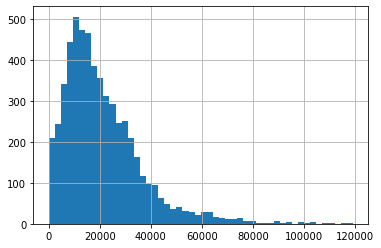

In [8]:
df_fiesta_mp['mileage'].hist(bins=50)

df_fiesta_mp['mileage'].sort_values().head(10)
df_fiesta_mp['mileage'].sort_values().tail(10)

In [9]:
df_fiesta_mp['mileage_5k'] = ((df_fiesta_mp['mileage'] / 5000).round(0)*5000 ).astype(int)
df_fiesta_mp['mileage_5k'].value_counts()
df_fiesta_mp.head(3)

10000     1022
15000      965
20000      726
5000       638
25000      598
30000      506
35000      318
0          216
40000      208
45000      121
50000       82
55000       60
60000       56
65000       42
75000       24
70000       21
80000       12
90000        8
85000        7
100000       5
105000       4
95000        4
110000       3
115000       2
120000       1
Name: mileage_5k, dtype: int64

,year,price,mileage,engineSize,mileage_5k
21193,2019,17500,10460,1.5,10000
21195,2015,10500,35432,1.6,35000
21197,2017,9000,13054,1.2,15000


In [10]:
def mad(s):
    return (s - s.mean() ).abs().mean()

In [11]:
df_fiesta_mp.groupby(['year', 'mileage_5k', 'engineSize'])['price'].mean().to_frame().sort_index().head(30).astype(int)

price
year mileage_5k engineSize       
1998 35000      1.2          2699
2000 45000      1.3          1995
2004 75000      1.2           950
     90000      1.4          2295
     110000     1.2           999
2005 120000     1.2          1295
2006 45000      1.2          2275
     65000      1.2          2395
     75000      1.2          2395
2007 50000      1.4          2895
     65000      1.2          2228
     80000      1.2          2100
     105000     1.4          1695
     110000     1.4          1295
     115000     1.4          1595
2008 55000      1.2          2250
                1.4          4490
                1.6          4299
     60000      1.2          2300
     70000      1.4          3499
     75000      1.2          2650
     80000      1.2          2028
                1.4          2500
     90000      1.4          1999
     95000      1.4          2175
     105000     1.2          1799
     115000     1.2          1695
2009 45000      1.2          3695
     50000      1.2          3784
                1.4          4000

# Encode

In [12]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

## transmission & fuelType

In [13]:
df_enc1 = df_fiesta_mp.copy()

In [14]:
# df_enc1['transmission'].value_counts()
# df_enc1['fuelType'].value_counts()

In [15]:
# t.ordinalEncode(df_enc1, ['transmission', 'fuelType'])

# df_enc1['transmission'].value_counts()
# df_enc1['fuelType'].value_counts()

In [16]:
df_enc1.head(3)
df_enc1.dtypes

,year,price,mileage,engineSize,mileage_5k
21193,2019,17500,10460,1.5,10000
21195,2015,10500,35432,1.6,35000
21197,2017,9000,13054,1.2,15000


year            int64
price           int64
mileage         int64
engineSize    float64
mileage_5k      int64
dtype: object

## make & model

In [17]:
# df_audi = df_enc1.loc[df_enc1['make'] == 'Audi'].drop(columns='make').copy()

# model_vc = df_audi['model'].value_counts()
# model_vc

# models_to_keep = model_vc[model_vc>10].index
# df_audi = df_audi.loc[ df_audi['model'].isin(models_to_keep) ]
# df_audi['model'].value_counts()
# t.oh_encode(df_audi, ['model'])

## Prep X y

In [18]:
df_train = df_enc1.drop(columns='mileage')

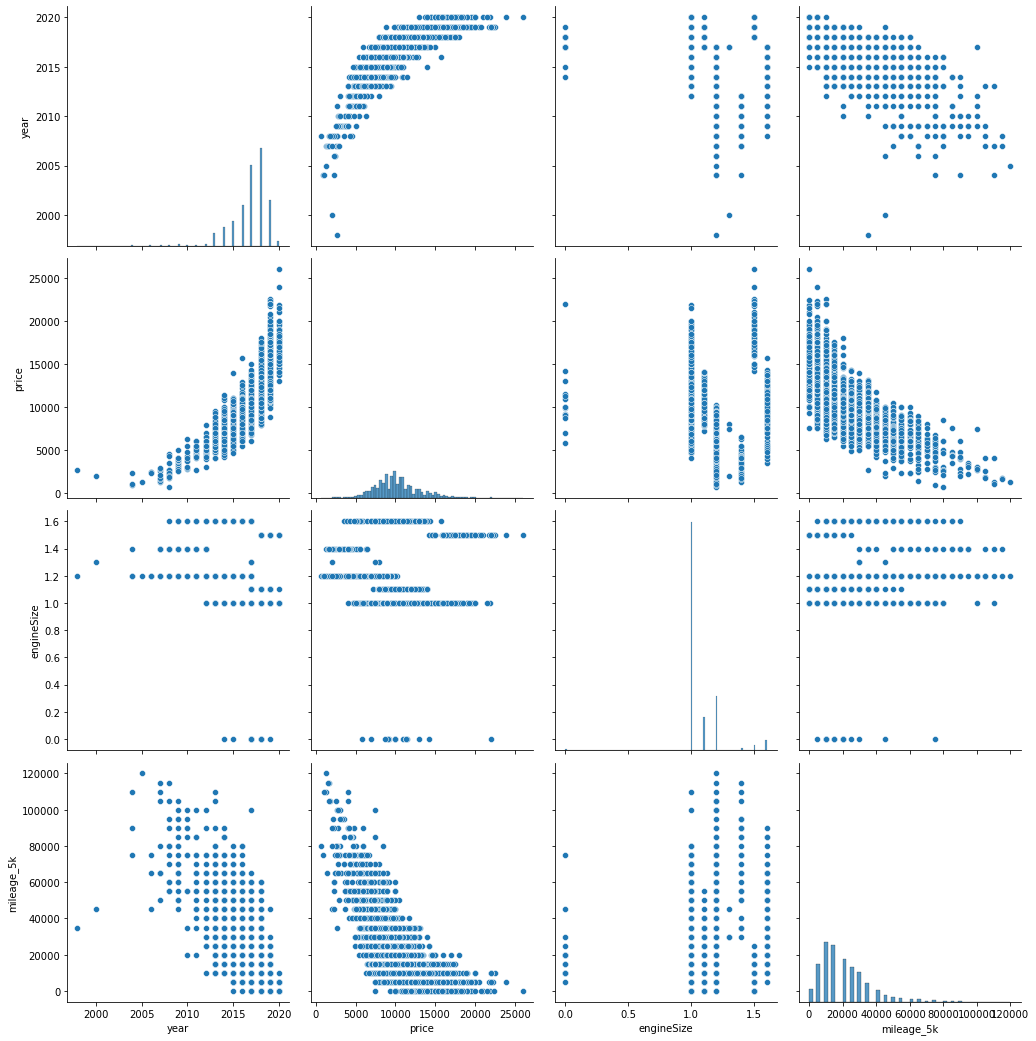

In [19]:
_ = sns.pairplot(data= df_train).fig.set_size_inches(15,15)

In [20]:
df_train.head(3)
df_train.dtypes

,year,price,engineSize,mileage_5k
21193,2019,17500,1.5,10000
21195,2015,10500,1.6,35000
21197,2017,9000,1.2,15000


year            int64
price           int64
engineSize    float64
mileage_5k      int64
dtype: object

In [21]:
X = df_train.drop('price', axis=1)
y = df_train['price']

In [22]:
X.shape
y.shape

(5649, 3)

(5649,)

# Framework

In [23]:
import itertools

def grid_exec(func, *args):
    return [func(*element) for element in itertools.product(*args)]

def grid_exec2(func, *args, on1Completed=None):
    all_results = []
    for param_product in itertools.product(*args):
        result = func(*param_product) 
        all_results.append(result)
        if on1Completed:
            on1Completed(all_results)
    return all_results

def grid_exec_callback(func, callback, *args):
    return [ callback(func(*element)) for element in itertools.product(*args)]

In [24]:
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold

from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score as r2

def rmse(y_true, y_pred):
    return mse(y_true, y_pred, squared=False)

In [25]:
all_trained_models = []

def cross_val(model_and_params, X, y, eval_metric, n_folds = 5):
    np.random.seed(RS)
    get_random = lambda  : np.random.randint(1, 2**16)
    
    cv_scores_dict = {}
    for metric in eval_metric:
        cv_scores_dict[metric.__name__] = []
            
    n_folds_completed = 0
    
    start_time = time.perf_counter()
    
    # cv = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_fold_repeats, random_state=get_random())
    cv = KFold(n_splits=n_folds)
    for i_fold, (idx_train, idx_test) in enumerate(cv.split(X)):
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].values
        X_test, y_test = X.iloc[idx_test], y.iloc[idx_test].values

        constructor, params_dic = model_and_params

        if 'random_state' in params_dic.keys():
            params_dic['random_state'] = get_random()

        model = constructor(**params_dic)
        all_trained_models.append(model)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # scores_dict = [ (metric.__name__, metric(y_test, y_pred)) for metric in eval_metric ]

        [ cv_scores_dict[metric.__name__].append(metric(y_test, y_pred)) for metric in eval_metric ]
        n_folds_completed += 1
        
    model_name = model.__class__.__name__
    model_params = params_dic.copy()
        
    total_elapsed_time = time.perf_counter() - start_time
    return model_name, model_params, n_folds_completed, total_elapsed_time, cv_scores_dict

In [26]:
def get_stats_df(cv_results):
    ret_list = []
    
    for result in cv_results:
        
        model_params = result[1]
        model_params.pop('random_state', None)
        model_params.pop('silent', None)
        
        result_dict = {}
        result_dict['model'] = result[0]
        result_dict['params'] = str(model_params).strip('{').strip('}')
        result_dict['n_folds'] = result[2]

        for k, v in result[4].items():
            result_dict[f'{k}_mean'] = np.mean(v)
            result_dict[f'{k}_std'] =  np.std(v)
        
        result_dict['time'] = result[3]

        ret_list.append(result_dict)
        
    return pd.DataFrame(ret_list)
    

def display_stats(df_stats, clear=True):
    styler = df_stats.style
    styler.format('{:,.1f}', 'time')\
          .bar(subset='time')

    for c in df_stats.columns[3: -1]:
        gmap = df_stats[c].rank()
        vmin = -0.1 * gmap.max()
        styler.background_gradient(cmap='Blues', subset=c, gmap=gmap, vmin=vmin)
        
        _range = df_stats[c].max() - df_stats[c].min()
        if _range < 1:
            styler.format('{:.3f}', c)
        elif _range < 10:
            styler.format('{:.1f}', c)
        # elif _range > 10:
        #     styler.format('{:.0f}', c)
        else:
            styler.format('{:.0f}', c)
            
    if clear:
        clear_output(wait=True)
    display(styler)

# Train model

In [27]:
from lightgbm import LGBMRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVC

In [41]:
all_results = []

In [42]:
n_est_list = [300]
models = [
    (LinearRegression, {}),
    (Lasso, {'random_state': RS}),
    (Ridge, {'random_state': RS}),
    (DecisionTreeRegressor, {}),
    *[ (RandomForestRegressor,         {'random_state': RS, 'n_estimators': n_e}) for n_e in n_est_list ],
    *[ (AdaBoostRegressor,         {'random_state': RS, 'n_estimators': n_e}) for n_e in [200, 400, 800] ],
    *[ (LGBMRegressor,         {'random_state': RS, 'n_estimators': n_e}) for n_e in n_est_list ],
]
metrics = [ mae, rmse, r2]
n_folds = [6]

r = grid_exec2(
    lambda model, n_folds: cross_val(model, X, y, metrics, n_folds), 
    models, n_folds, 
    on1Completed = lambda r: display_stats(get_stats_df(r))
)


,model,params,n_folds,mean_absolute_error_mean,mean_absolute_error_std,rmse_mean,rmse_std,r2_score_mean,r2_score_std,time
0,LinearRegression,,6,1230,65,1656,126,0.631,0.031,0.0
1,Lasso,,6,1230,65,1656,126,0.631,0.031,0.1
2,Ridge,,6,1230,65,1656,126,0.631,0.031,0.0
3,DecisionTreeRegressor,,6,749,45,1005,67,0.863,0.017,0.0
4,RandomForestRegressor,'n_estimators': 300,6,745,46,998,68,0.865,0.018,4.6
5,AdaBoostRegressor,'n_estimators': 200,6,1067,64,1329,75,0.759,0.044,0.6
6,AdaBoostRegressor,'n_estimators': 400,6,1067,64,1329,75,0.759,0.044,0.7
7,AdaBoostRegressor,'n_estimators': 800,6,1067,64,1329,75,0.759,0.044,0.6
8,LGBMRegressor,'n_estimators': 300,6,744,45,998,66,0.865,0.017,1.2


In [48]:
# all_results.extend(r)
# display_stats(get_stats_df(all_results))

In [49]:
n_est_list = [300]
models = [
    (LinearRegression, {}),
    # (Lasso, {'random_state': RS}),
    # (Ridge, {'random_state': RS}),
]
metrics = [ mae, rmse, r2]
n_folds = [6]

loop_metrics = []

for i in range(9):
    X_p = pd.DataFrame(data=PolynomialFeatures(degree=i).fit_transform(X))
    r = grid_exec2(
        lambda model, n_folds: cross_val(model, X_p, y, metrics, n_folds), 
        models, n_folds, 
        # on1Completed = lambda r: display_stats(get_stats_df(r))
    )
    loop_metrics.extend(r)
    display_stats(get_stats_df(loop_metrics))

,model,params,n_folds,mean_absolute_error_mean,mean_absolute_error_std,rmse_mean,rmse_std,r2_score_mean,r2_score_std,time
0,LinearRegression,,6,2148,251,2828,305,-0.1,0.1,0.0
1,LinearRegression,,6,1230,65,1656,126,0.6,0.0,0.0
2,LinearRegression,,6,1190,256,2166,1716,0.1,1.5,0.1
3,LinearRegression,,6,1035,297,2099,2057,-0.0,1.9,0.1
4,LinearRegression,,6,1148,234,2287,2097,-0.2,2.0,0.1
5,LinearRegression,,6,1170,235,2198,1825,0.0,1.6,0.1
6,LinearRegression,,6,1175,220,2138,1648,0.1,1.4,0.1
7,LinearRegression,,6,1217,236,2526,2393,-0.5,2.6,0.2
8,LinearRegression,,6,1293,348,2256,1668,0.0,1.4,0.3


In [47]:
# all_results.extend(loop_metrics)
# display_stats(get_stats_df(all_results))

In [29]:
from sklearn.preprocessing import PolynomialFeatures

In [30]:
# n_est_list = [300]
# models = [
#     (LinearRegression, {}),
#     # (Lasso, {'random_state': RS}),
#     # (Ridge, {'random_state': RS}),
#     (DecisionTreeRegressor, {}),
#     # *[ (RandomForestRegressor,         {'random_state': RS, 'n_estimators': n_e}) for n_e in n_est_list ],
#     # *[ (AdaBoostRegressor,         {'random_state': RS, 'n_estimators': n_e}) for n_e in [200, 400, 800] ],
#     # *[ (LGBMRegressor,         {'random_state': RS, 'n_estimators': n_e}) for n_e in n_est_list ],
# ]
# metrics = [ mae, rmse, r2]
# n_folds = [6]

# for i in range(9):
#     X_p = pd.DataFrame(data=PolynomialFeatures(degree=i).fit_transform(X))
#     r = grid_exec2(
#         lambda model, n_folds: cross_val(model, X_p, y, metrics, n_folds), 
#         models, n_folds, 
#     )

# # get_stats_df(r)
# display_stats(get_stats_df(r))

d['std'].mean() # 681.9749646281762

d['mad'].mean() # 344.70436925937224